In [1]:
from SpaLP.utils import prepare_inputs, set_seed,create_new_color_dict,Graph
from SpaLP.LP import SpatialLocalPooling
import torch
import torch.nn as nn
import torch.optim as optim
import warnings
import scanpy as sc
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import anndata as ad
from tqdm import tqdm
import time

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
set_seed(7)

In [4]:
adata=sc.read_h5ad('/home/dbj/SpaLP/Tutorialdata/Xenium_Breast_Cancer.h5ad')
adata.var_names_make_unique()
adata.obs['type']='Pre-training data'

In [5]:
sc.pp.normalize_total(adata, target_sum=1e4,inplace=True)
sc.pp.log1p(adata)
sc.pp.scale(adata)
adata.obsm['feat']=adata.X

In [6]:
k=3
graph = prepare_inputs(adata, k, device)

In [7]:
in_channels = graph.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=64).to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [8]:
set_seed(7)
epochs = 200
pbar = tqdm(range(epochs), desc="Training",ncols=200)
for epoch in pbar:
    start_time = time.time()
    model.train()
    optimizer.zero_grad()
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    loss = criterion(reconstructed, graph.features)
    loss.backward()
    optimizer.step()
    elapsed = time.time() - start_time
    pbar.set_postfix({"Epoch": epoch,"Loss": f"{loss.item():.4f}"})

Training: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 200/200 [00:07<00:00, 25.24it/s, Epoch=199, Loss=0.8892]


In [9]:
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph.features, graph.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

In [10]:
adata.obsm['SpaLP']=embedding

In [11]:
sc.pp.neighbors(adata, use_rep='SpaLP')
sc.tl.leiden(adata, random_state=2024, resolution=0.4,key_added='SpaLP')

IOStream.flush timed out
IOStream.flush timed out
IOStream.flush timed out


In [12]:
torch.save(model.state_dict(), "/home/dbj/SpaLP/gittest/SpaLP/general/Xenium_pretrian_model.pth")

In [13]:
adata.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/Pre-training.h5ad',compression='gzip')

In [14]:
from SpaLP.utils import transfer_labels_by_cosine

In [15]:
adata1=sc.read_h5ad('/home/dbj/SpatialSLM/datasets/GraphST/Xeniumbreastcancer/Xeniumbreastcancer2.h5ad')
adata1.var_names_make_unique()
adata1.obs['type']='Inference data'

In [16]:
sc.pp.normalize_total(adata1, target_sum=1e4,inplace=True)
sc.pp.log1p(adata1)
sc.pp.scale(adata1)
adata1.obsm['feat']=adata1.X

In [17]:
graph1 = prepare_inputs(adata1, k=3, device=device)

In [18]:
in_channels = graph1.features.shape[1]
model = SpatialLocalPooling(in_channels, out_channels=64).to(device)
model.load_state_dict(torch.load("/home/dbj/SpaLP/gittest/SpaLP/general/Xenium_pretrian_model.pth", map_location="cpu"))
model.eval()
with torch.no_grad():
    reconstructed,embedding = model(graph1.features, graph1.neighbor_idx)
    reconstructed = reconstructed.cpu().numpy()
    embedding=embedding.cpu().numpy()

adata1.obsm['SpaLP']=embedding

In [19]:
Pre_train_data=sc.read_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/Pre-training.h5ad')

In [20]:
adata1=transfer_labels_by_cosine(pre_adata=Pre_train_data,new_adata=adata1,label_key='SpaLP',embedding_key='SpaLP')

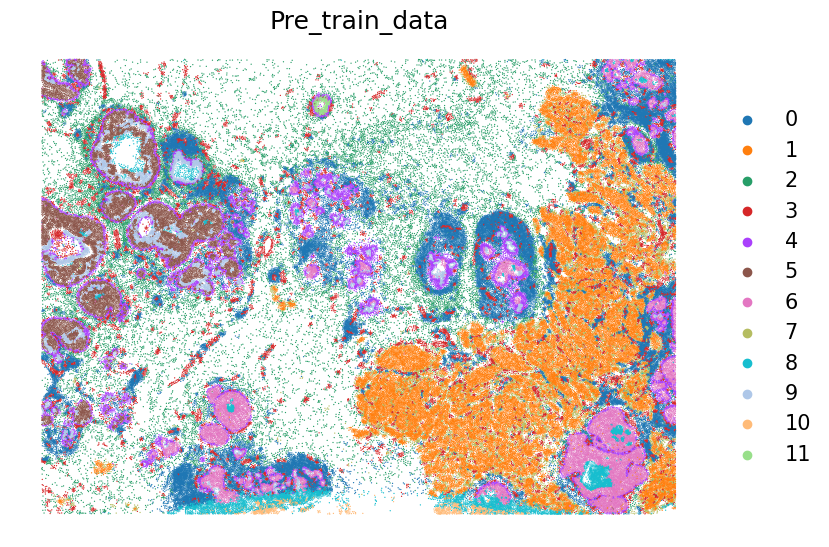

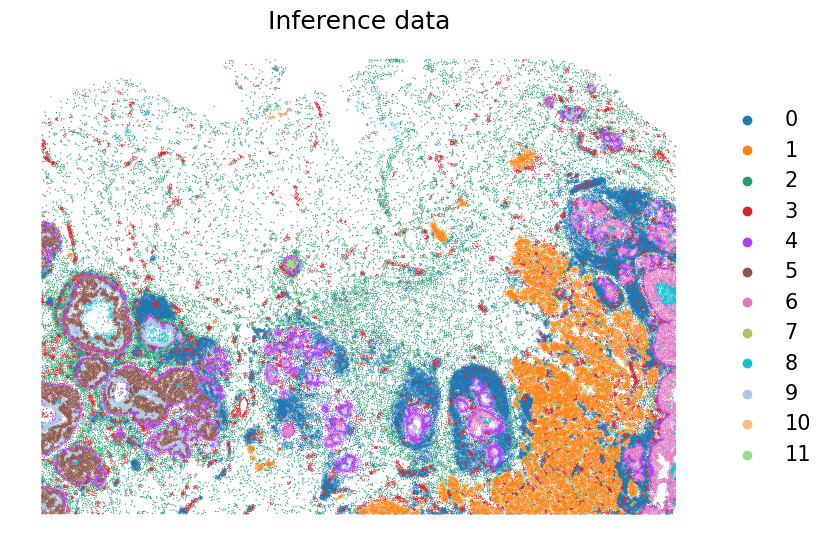

In [22]:
import matplotlib.pyplot as plt
import copy
plt.rcParams['figure.figsize'] = (9,6.5)
plt.rcParams['font.size'] = 15
sc.pl.embedding(Pre_train_data,color='SpaLP',basis='spatial',s=3.5,title='Pre_train_data',frameon=False)
sc.pl.embedding(adata1,color='Transfer_label',basis='spatial',s=3.5,title='Inference data',frameon=False)

In [23]:
adata1.write_h5ad('/home/dbj/SpaLP/gittest/SpaLP/general/transfer.h5ad',compression='gzip')